# Neptune + Fastai
## Before you start
### Install dependencies

In [1]:
!pip install --quiet neptune-client[fastai]==0.9.18 fastai==2.3.1

     |████████████████████████████████| 245kB 4.0MB/s 
     |████████████████████████████████| 204kB 11.2MB/s 
     |████████████████████████████████| 829kB 11.3MB/s 
     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 174kB 13.7MB/s 
     |████████████████████████████████| 804.1MB 17kB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 133kB 58.7MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.8.1 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.8.1 which is incompatible.


# Basic Example

**Import libraries**

In [18]:
import fastai
from fastai.vision.all import *
from neptune.new.integrations.fastai import NeptuneCallback
import neptune.new as neptune
from neptune.new.types import File

## Step 1: Create a Neptune run

To log metadata to the Neptune project, you need the `project name` and the `api_token`.

To make this example easy to follow, we have created a public project **'common/fastai-integration'** and a shared user **'neptuner'** with the API token **'ANONYMOUS'**. As you will see in the code cell below.

**(Optional)** To log to your Neptune project:

* [Create a Neptune account](https://app.neptune.ai/register/)

* [Find your API token](https://docs.neptune.ai/getting-started/installation#authentication-neptune-api-token)
* [Find your project name](https://docs.neptune.ai/getting-started/installation#setting-the-project-name)

Pass your credentials to project and api_token arguments of neptune.init()

`run = neptune.init(api_token='<YOUR_API_TOKEN>', project='<YOUR_WORKSPACE/YOUR_PROJECT>')` # pass your credentials


In [51]:
run = neptune.init(project='common/fastai-integration', run='FAS-54', api_token='ANONYMOUS')

https://app.neptune.ai/common/fastai-integration/e/FAS-54
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


**Dataset**

In [4]:
path = untar_data(URLs.MNIST_TINY)

In [5]:
dls = ImageDataLoaders.from_csv(path)

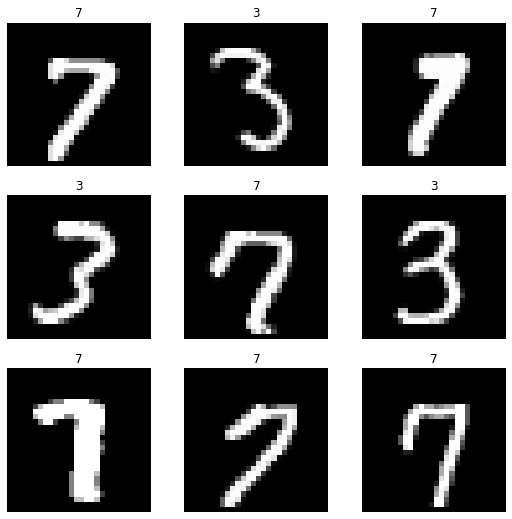

In [6]:
dls.show_batch()

## Step 2: Log metadata using NeptuneCallback()
Using NeptuneCallback the following is automatically logged to Neptune UI for you:
- Hyperparameters
- Loss
- Metrics
- Best model weights 
- Model architecture


In [7]:
learn = cnn_learner(dls, resnet18, cbs=[NeptuneCallback(run, 'experiment')])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [8]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.700565,0.295107,00:09


Better model found at epoch 0 with valid_loss value: 0.2951069176197052.


# More options


### Step 3: Single and Multi phase logging

#### Log on a single training phase

In [ ]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
learn.fit_one_cycle(3, cbs = [NeptuneCallback(run, 'bs', save_model_freq= 2)])

epoch,train_loss,valid_loss,time
0,0.712470,0.309837,00:09


Better model found at epoch 0 with valid_loss value: 0.30983734130859375.


#### Log all training phases of the learner

In [ ]:
learn = cnn_learner(dls, resnet18, cbs=[NeptuneCallback(run, 'experiment')])

In [ ]:
learn.fit_one_cycle(2)

In [ ]:
learn.fit_one_cycle(2)

### Step 4: Model weights

1. By default NeptuneCallback() saves and logs the best model for you automatically. 
You can disable it by setting `save_best_model` arg to False.

2. Log Every N epochs

In [ ]:
n = 4
learn = cnn_learner(dls, resnet18, cbs=[NeptuneCallback(run, 'experiment', save_model_freq=n)])

In [ ]:
learn.fit_one_cycle(8)

 3. Add SaveModelCallback 

  If you want to log your model weight files during single training phase then add  SavemodelCallback().

In [ ]:
learn.fit_one_cycle(1, cbs=[SaveModelCallback(), NeptuneCallback(run, 'experiment')])

### Step 5: Log images

In [59]:
batch = dls.one_batch()
for i, (x,y) in enumerate(dls.decode_batch(batch)[:2]):
    # Neptune supports torch tensors
    # fastai uses their own tensor type name TensorImage 
    # so you have to convert it back to torch.Tensor
    run['images/one_batch'].log(File.as_image(x.as_subclass(torch.Tensor).permute(2,1,0).clip(0,1)), name = f'{y}')
    

# Stop Run

In [ ]:
run.stop()